In [1]:
%load_ext autoreload
%autoreload 2

from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt

import ccxt

In [6]:
import json

hyperliquid = ccxt.hyperliquid()
market_info = hyperliquid.load_markets()['BERA/USDC:USDC']
print(json.dumps(market_info['info'], indent=4))

{
    "szDecimals": "1",
    "name": "BERA",
    "maxLeverage": "5",
    "funding": "-0.0000137479",
    "openInterest": "3560553.0",
    "prevDayPx": "4.9664",
    "dayNtlVlm": "29215141.7363200001",
    "premium": "0.0",
    "oraclePx": "4.1815",
    "markPx": "4.1783",
    "midPx": "4.17985",
    "impactPxs": [
        "4.1783",
        "4.18396"
    ],
    "dayBaseVlm": "6518045.1000000024",
    "baseId": 180
}


Fetching funding rates:  12%|█▎        | 1/8 [00:02<00:16,  2.33s/it]

kucoin: <class 'ccxt.base.errors.NotSupported'>


Fetching funding rates: 100%|██████████| 8/8 [00:23<00:00,  2.92s/it]

vertex: <class 'ccxt.base.errors.NotSupported'>


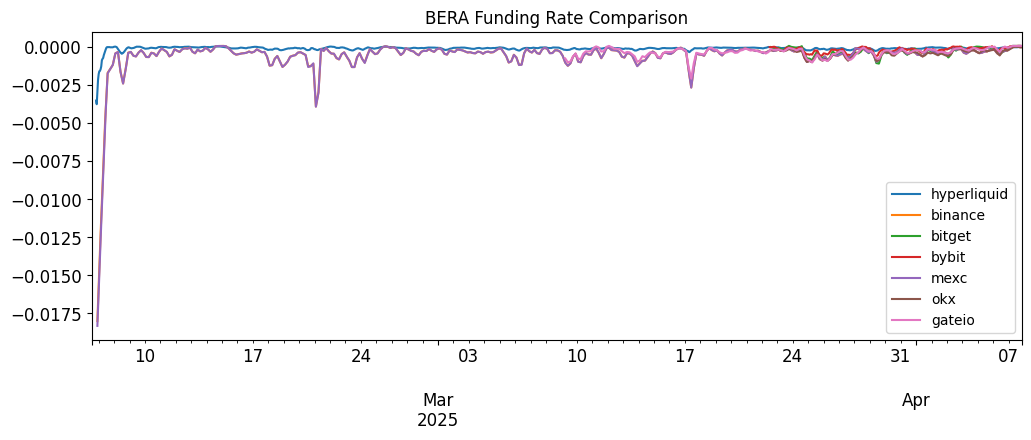

In [119]:
def hyperliquid_funding_rate(ticker, start=None, end=None):
    #hyperliquid.fetchFundingRateHistory(symbol=f"{ticker}/USDC:USDC", since=start, limit=500)
    all_funding_rates = []
    while start < end:
        funding_rate_history = hyperliquid.fetchFundingRateHistory(symbol=f"{ticker}/USDC:USDC", since=start, limit=500)
        if not funding_rate_history:
            break
        all_funding_rates.extend(funding_rate_history)
        start = funding_rate_history[-1]['timestamp'] + 1  # Move start to the next timestamp

    result = {entry['timestamp']: entry['fundingRate'] for entry in all_funding_rates}
    return result

# fetch funding rate history for several exchanges
comparison_info = {
    #'hyperliquid': [ccxt.hyperliquid(), 'BERA/USDC:USDC'],
    'binance': [ccxt.binance(), 'BERA/USDT:USDT'],
    'kucoin': [ccxt.kucoin(), 'BERA/USDT:USDT'],
    'bitget': [ccxt.bitget(), 'BERA/USDT:USDT'],
    'bybit': [ccxt.bybit(), 'BERA/USDT:USDT'],
    'mexc': [ccxt.mexc(), 'BERA/USDT:USDT'],
    'okx': [ccxt.okx(), 'BERA/USDT:USDT'],
    'gateio': [ccxt.gateio(), 'BERA/USDT:USDT'],
    'vertex': [ccxt.vertex(), 'BERA/USDC:USDC'],
}

start = int(datetime(2025, 2, 1).timestamp() * 1000)
end = int(datetime.now().timestamp() * 1000)

comparison_funding_rates = {
    'hyperliquid': hyperliquid_funding_rate('BERA', start=start, end=end)
}

for exchange, info in tqdm(comparison_info.items(), desc='Fetching funding rates', total=len(comparison_info)):
    exchange_instance = info[0]
    symbol = info[1]
    try:
        funding_rate_history = exchange_instance.fetchFundingRateHistory(symbol, limit=500)
        funding_rate_dict = {entry['timestamp']: entry['fundingRate'] for entry in funding_rate_history}
        comparison_funding_rates[exchange] = funding_rate_dict
    except:
        print(f"{exchange}: {sys.exc_info()[0]}")
        continue

pd.DataFrame(comparison_funding_rates).sort_index()
df = pd.DataFrame(comparison_funding_rates)
df.index = pd.to_datetime(df.index, unit='ms', utc=True)
df.index = df.index - timedelta(seconds=0.5)
df = df.resample('h').last()
df.ffill(limit=12).rolling(8).mean().loc[df['hyperliquid'].first_valid_index():].plot(
    figsize=(12, 4), 
    title='BERA Funding Rate Comparison', 
    fontsize=12
);

In [162]:
start = int((datetime.now() - timedelta(days=90)).timestamp() * 1000)
end = int(datetime.now().timestamp() * 1000)

funding_rate_history = hyperliquid_funding_rate("BERA", start=start, end=end)
perp_candles = hyperliquid.fetch_ohlcv("BERA/USDC:USDC", timeframe='1h', since=start)
perp_candles = pd.DataFrame(
    perp_candles, 
    columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
).set_index('timestamp')
perp_close = perp_candles['close']
perp_close.index = perp_close.index + 60*60*1000

binance = ccxt.binance()
spot_candles = binance.fetch_ohlcv('BERA/USDT', '1h', limit=2000)
spot_candles = pd.DataFrame(
    spot_candles, 
    columns=['timestamp', 'open', 'high', 'low', 'close', 'volume']
).set_index('timestamp')
spot_close = spot_candles['close']
spot_close.index = spot_close.index + 60*60*1000

perp_history_df = pd.DataFrame({
    'perp_close': perp_close,
    'spot_close': spot_close,
    'funding_rate': funding_rate_history
})
perp_history_df.index = pd.to_datetime(perp_history_df.index, unit='ms', utc=True)
perp_history_df = perp_history_df.resample('h').last().dropna()
perp_history_df.tail()

,perp_close,spot_close,funding_rate
2025-04-07 18:00:00+00:00,4.2693,4.271,0.000013
2025-04-07 19:00:00+00:00,4.2396,4.243,0.000013
2025-04-07 20:00:00+00:00,4.1578,4.161,-0.000021
2025-04-07 21:00:00+00:00,4.2226,4.228,0.000007
2025-04-07 22:00:00+00:00,4.3387,4.336,0.000013


In [ ]:
# Initial position size in USD
initial_position = 3_000_000
position_size = initial_position / perp_history_df['close']
price_pnl = position_size.shift(1) * (perp_history_df['close'].shift(1) - perp_history_df['close'])
funding_pnl = position_size.shift(1) * perp_history_df['fundingRate'] * perp_history_df['close']
total_pnl = price_pnl + funding_pnl
cumulative_pnl = total_pnl.cumsum()

total_return = cumulative_pnl.iloc[-1]
print(f"Total return of being short the perp: ${total_return:,.2f}")

Total return of being short the perp: $1,857,836.42


In [ ]:
bera_position = 1_184_000
spot_discount = 0.4
hedge_ratio = 1.0

start_date = pd.to_datetime('2025-02-25 08:00:00+00:00')
data = perp_history_df.loc[start_date:]

spot_usd_value = data['spot_close'] * bera_position 
spot_usd_cost = data['spot_close'].iloc[0] * bera_position * (1 - spot_discount)
perp_bera_position = bera_position * hedge_ratio
funding_payment = perp_bera_position * data['funding_rate'].shift(1).fillna(0) * data['perp_close']
perp_usd_initial_value = data['perp_close'].iloc[0] * perp_bera_position
perp_usd_pnl = perp_bera_position * (data['perp_close'].shift(1) - data['perp_close'])
perp_usd_value = perp_usd_initial_value + perp_usd_pnl.fillna(0).cumsum() 
#funding_payment.cumsum()

position_usd_value = pd.DataFrame({
    'spot_usd_value': spot_usd_value,
    'perp_usd_value': perp_usd_value,
    'funding_payment': funding_payment.cumsum()
})

cumulative_return = pd.DataFrame({
    'spot_position_return': spot_usd_value / spot_usd_cost - 1,
    'perp_position_return': (perp_usd_value / perp_usd_initial_value) - 1
})
cumulative_return['total_return'] = cumulative_return['spot_position_return'] + cumulative_return['perp_position_return']

In [322]:
data.to_clipboard()

In [320]:
position_usd_value = pd.DataFrame({
    'spot_usd_value': spot_usd_value,
    'perp_usd_value': perp_usd_value,
    #'funding_payment': funding_payment.cumsum()
})
position_usd_value

# position_usd_value['delta'] = position_usd_value['spot_usd_value'] - position_usd_value['perp_usd_value']
# position_usd_value.plot()

,spot_usd_value,perp_usd_value
2025-02-25 08:00:00+00:00,7325408.0,7.324579e+06
2025-02-25 09:00:00+00:00,7488800.0,7.161636e+06
2025-02-25 10:00:00+00:00,7288704.0,7.366386e+06
2025-02-25 11:00:00+00:00,7350272.0,7.295788e+06
2025-02-25 12:00:00+00:00,7452096.0,7.199000e+06
...,...,...
2025-04-07 18:00:00+00:00,5056864.0,8.736675e+06
2025-04-07 19:00:00+00:00,5023712.0,8.771903e+06
2025-04-07 20:00:00+00:00,4926624.0,8.868815e+06
2025-04-07 21:00:00+00:00,5005952.0,8.791985e+06


<Axes: title={'center': 'Hedge Error / Funding Contribution'}>

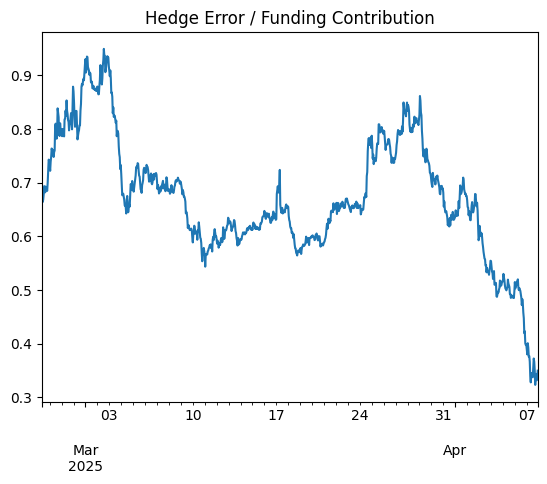

In [299]:
cumulative_return['delta'] = cumulative_return['spot_position_return'] + cumulative_return['perp_position_return']
cumulative_return['delta'].plot(title='Hedge Error / Funding Contribution')

<Axes: >

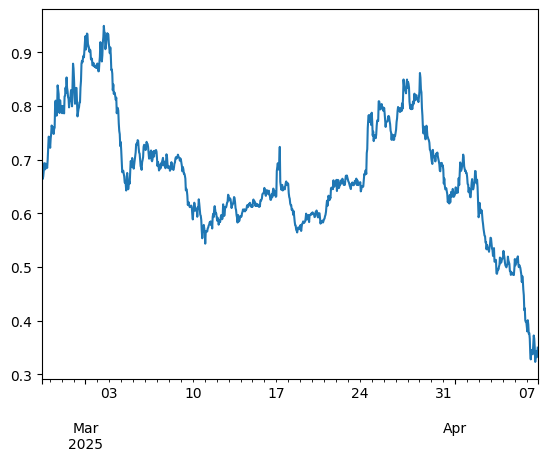

In [297]:
cumulative_return = pd.DataFrame({
    'spot_position_return': spot_usd_value / spot_usd_cost - 1,
    'perp_position_return': (perp_usd_value / perp_usd_initial_value) - 1
})
cumulative_return['total_return'] = cumulative_return['spot_position_return'] + cumulative_return['perp_position_return']
cumulative_return['total_return'].plot()

<Axes: xlabel='timestamp'>

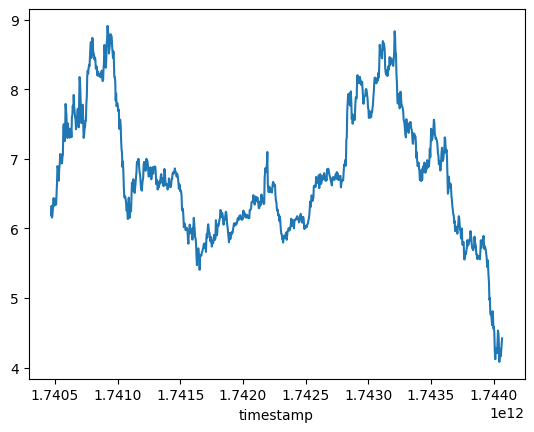

In [293]:
spot_close.plot()

<Axes: >

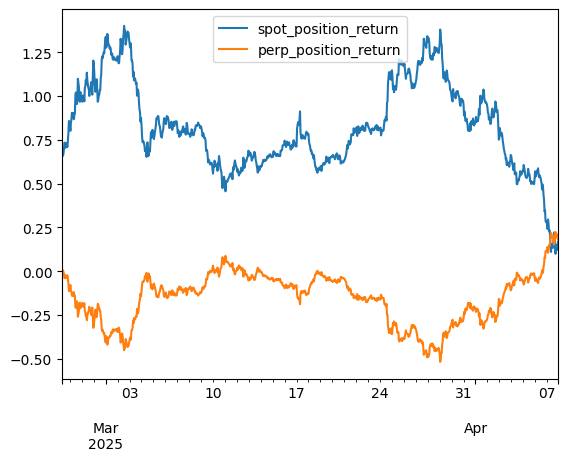

In [298]:
cumulative_return.drop(columns=['total_return']).plot()

In [ ]:
# Hedge Basket


timestamp
1738846800000        NaN
1738850400000    12.3810
1738854000000    11.2840
1738857600000     8.5597
1738861200000     8.8401
                  ...   
1744048800000     4.2693
1744052400000     4.2396
1744056000000     4.1578
1744059600000     4.2226
1744063200000     4.3387
Name: close, Length: 1450, dtype: float64